In [1]:
import numpy as np
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

In [3]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

In [4]:
# Переименовываем колонку с ценой
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

In [5]:
# Объединение данных
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)

combined_df = combined_df.set_index('dt', drop=True)

In [6]:
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :]

In [7]:
# Разделение данных
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [8]:
# Логарифмирование целевой переменной
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
# Подбор гиперпараметров
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.02, 0.05],
    'depth': [4, 5, 6],
    'l2_leaf_reg': [1, 3, 5],
    'early_stopping_rounds': [50, 100]
}

catboost = CatBoostRegressor(loss_function='MAE', has_time=True, verbose=0)

In [10]:
grid_search = GridSearchCV(catboost, param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train_log)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F4C132B890>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6], 'early_stopping_rounds': [50, 100],
                         'iterations': [500, 1000], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.02, 0.05]},
             scoring='neg_mean_absolute_error')

In [11]:
# Лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'depth': 4, 'early_stopping_rounds': 50, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.02}


In [12]:
# Обучение модели с лучшими параметрами
model = CatBoostRegressor(**best_params, loss_function='MAE', has_time=True)
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

0:	learn: 0.1818516	test: 0.4581196	best: 0.4581196 (0)	total: 440us	remaining: 220ms
1:	learn: 0.1786210	test: 0.4503552	best: 0.4503552 (1)	total: 750us	remaining: 187ms
2:	learn: 0.1759264	test: 0.4427113	best: 0.4427113 (2)	total: 1.11ms	remaining: 183ms
3:	learn: 0.1728553	test: 0.4344062	best: 0.4344062 (3)	total: 1.43ms	remaining: 177ms
4:	learn: 0.1696944	test: 0.4262113	best: 0.4262113 (4)	total: 1.69ms	remaining: 167ms
5:	learn: 0.1671339	test: 0.4206459	best: 0.4206459 (5)	total: 1.89ms	remaining: 155ms
6:	learn: 0.1639390	test: 0.4134105	best: 0.4134105 (6)	total: 2.11ms	remaining: 149ms
7:	learn: 0.1618338	test: 0.4101489	best: 0.4101489 (7)	total: 2.31ms	remaining: 142ms
8:	learn: 0.1596101	test: 0.4041676	best: 0.4041676 (8)	total: 2.52ms	remaining: 138ms
9:	learn: 0.1571462	test: 0.4015274	best: 0.4015274 (9)	total: 2.71ms	remaining: 133ms
10:	learn: 0.1547951	test: 0.3983983	best: 0.3983983 (10)	total: 2.91ms	remaining: 129ms
11:	learn: 0.1517845	test: 0.3900933	best: 

In [13]:
mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

0:	learn: 0.1399757	total: 269us	remaining: 134ms
1:	learn: 0.1376622	total: 428us	remaining: 107ms
2:	learn: 0.1354173	total: 531us	remaining: 88.1ms
3:	learn: 0.1331035	total: 657us	remaining: 81.6ms
4:	learn: 0.1310020	total: 767us	remaining: 76ms
5:	learn: 0.1288923	total: 860us	remaining: 70.9ms
6:	learn: 0.1267259	total: 947us	remaining: 66.7ms
7:	learn: 0.1242981	total: 1.07ms	remaining: 66ms
8:	learn: 0.1222137	total: 1.19ms	remaining: 64.8ms
9:	learn: 0.1202129	total: 1.28ms	remaining: 62.9ms
10:	learn: 0.1179374	total: 1.38ms	remaining: 61.2ms
11:	learn: 0.1160952	total: 1.49ms	remaining: 60.5ms
12:	learn: 0.1138687	total: 1.61ms	remaining: 60.4ms
13:	learn: 0.1119422	total: 1.73ms	remaining: 60.2ms
14:	learn: 0.1103623	total: 1.85ms	remaining: 59.9ms
15:	learn: 0.1083026	total: 1.96ms	remaining: 59.2ms
16:	learn: 0.1062881	total: 2.05ms	remaining: 58.4ms
17:	learn: 0.1045991	total: 2.15ms	remaining: 57.5ms
18:	learn: 0.1029747	total: 2.23ms	remaining: 56.5ms
19:	learn: 0.100

In [14]:
# Предсказание
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9329
MAE: 2219.5498
MSE: 8790788.8757
RMSE: 2964.9265
Средний MAE на кросс-валидации: 0.0518
Средний R² на кросс-валидации: 0.7669


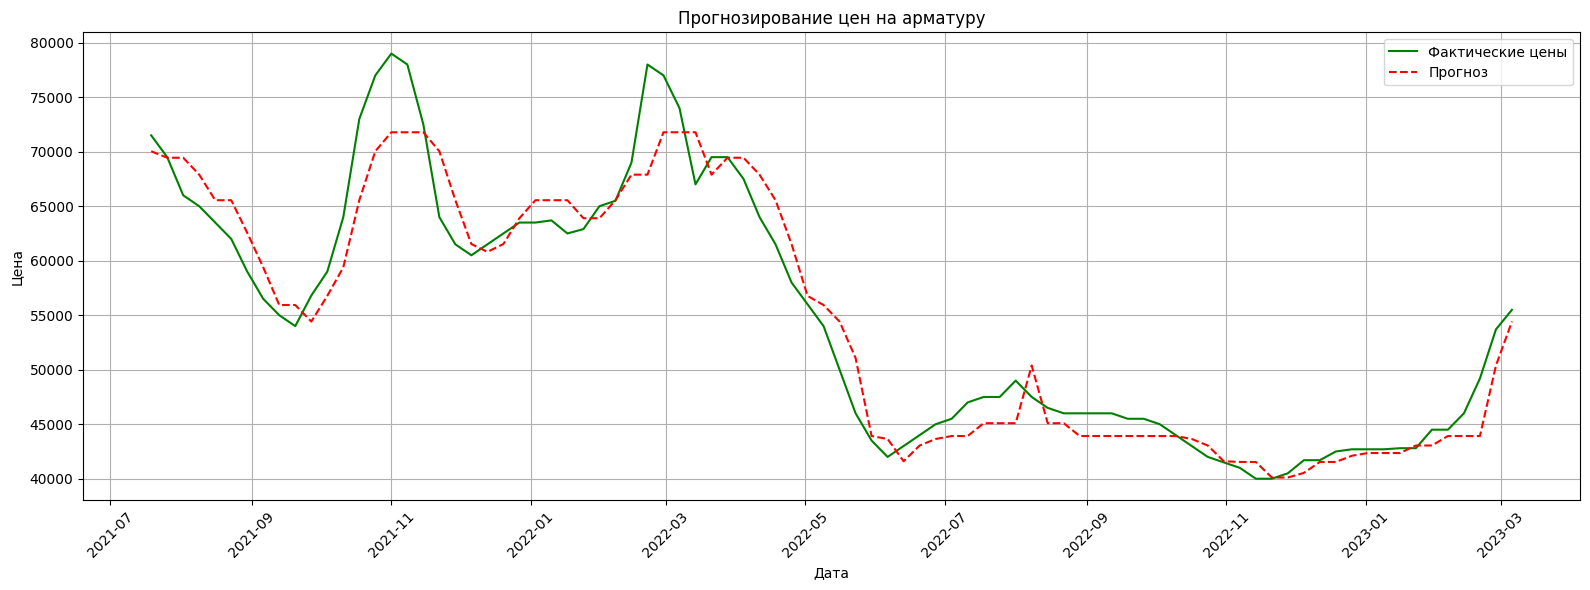

In [15]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
model.save_model("catboostmodel_Marin.cbm")